# Laboratorio 6.
## Análisis de Redes Sociales

---
Participantes:


*   María Isabel Montoya Valladares 19169
*   Luis Pedro García Salazar 19344
* María José Morales Reichenbach 19145

### Instrucciones
Puede realizar uno de los 3 problemas que se le presentan. Debe extraer los datos de una red social del tema que escoja trabajar. Debe hacer un análisis exploratorio para entender mejor los datos. Debe descubrir patrones interesantes. Recuerde que la investigación debe ser reproducible por lo que debe guardarel código que ha utilizado para resolver los ejerciciosy/o cada uno de los pasos llevados a cabo si utiliza una herramienta visual. Este laboratorio debe realizarse en grupos de 3.Inscríbase en uno de los grupos que hay en canvas para la actividad.

### Problema escogido
<b>PROBLEMA 2.</b> Extraiga los datos relacionados con el  tráfico en la  ciudad de Guatemala, puede utilizar cualquier red social, a la que se tenga acceso, y pueden extraerse datos de varias. Por ejemplo si extrae datos de twitter podría utilizar loshashtag #TraficoGT,#TransitoGTo @amilcarmontejo. Explore los datos que  extraiga  y  descubra  conocimiento,  tendencias  y  elementos  interesantes.¿Será  que la pandemia ha ayudado a disminuir el tráfico?

In [6]:
from config import *
import tweepy, json
import datetime
import pandas as pd
import re
import string
from matplotlib import pyplot as plt
from nltk.corpus import stopwords #eliminacion de stopwrod



auth = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)

Como queremos comparar tráfico antes de pandemia y en pandemia crearemos fechas. La pandemia inicio el 13 de marzo de 2020. Desde esa fecha hasta hoy 5 de septiembre a pasado 1 año y medio de tiempo por lo que se obtendran dos conjuntos de tweets. Uno comenzando el 13/03/2020 hasta el dia de hoy y otro comenzando 13/09/2019 hasta el 12/03/2020 para tener aproximadamente la misma cantidad de tiempo en ambos y poder hacer una compararación.

In [71]:
inPrePan = datetime.datetime(2019, 9, 13)
finPrePan = datetime.datetime(2020, 3, 12)
inPan = datetime.datetime(2020, 3, 13)
finPan = datetime.datetime.now()

inPrePan, finPrePan, inPan, finPan

(datetime.datetime(2019, 9, 13, 0, 0),
 datetime.datetime(2020, 3, 12, 0, 0),
 datetime.datetime(2020, 3, 13, 0, 0),
 datetime.datetime(2021, 9, 5, 18, 46, 26, 283376))

Buscamos los tweets usando la funcion de cursos de tweepy.

In [29]:
import csv
def gtweets(word, num, since, path, retweets, mode):
    if not retweets: 
        word = word + '-filter:retweets'
    if mode == 'print':
        for tweet in tweepy.Cursor(api.search, q=word, since=since).items(num):
            print(tweet.text,'\n')
    elif mode == 'save':
        with open(path, 'a') as csv_file:
            csv_writer = csv.writer(csv_file)
            for tweet in tweepy.Cursor(api.search, q=word, since=since).items(num):
                csv_writer.writerow([tweet.id,tweet.created_at,tweet.text,tweet.favorite_count,tweet.retweet_count])

keyword = ['#TraficoGT', 'accidente']
num = 1000
since = '2019-09-13'
path = "../tweet_trafico.csv"
retweets = False
mode = 'save'
#se comenta esta parte porque ya se tiene el archivo csv
#for i in keyword:
#    gtweets(i, num, since, path, retweets, mode)

KeyboardInterrupt: 

In [35]:

datos=pd.read_csv('tweet_trafico.csv', header=None)
datos.columns = ['id', 'create', 'tweet_text', 'rt','fv']
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,Regresó el #TraficoGT a Ciudad de #Guatemala 😳😳,0,0
1,1435037738806517763,2021-09-07 00:30:33,Mientras en @CongresoGuate esta va cafecito. L...,0,0
2,1435035666870673416,2021-09-07 00:22:19,Como PUERCAS creen que uno logra llegar a las ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,#TraficoGT 🚨🚨👉 https://t.co/iaHmWbJnx3\n\nIng...,0,0
4,1435005350592266240,2021-09-06 22:21:51,Cada vez más el tráfico obliga a las personas ...,0,0


Ahora podemos observar un head con el tweet id, date y text de los tweets correspondientes a lo que el API nos deja acceso. Por lo que se procede a hacer los procesos de limpieza.
### Limpieza y Procesamiento de Datos
Para la limpieza de los datos se haran cambios de todas las letras a minusculas, se eliminaran los signos de puntuación, emojis, URLs y stopwords. 

#### De Mayuscula a minuscula
Todas las palabras se vuelven minuscula para poder tener en el mismo grupo todas las palabras iguales y que se tome la popularidad de la palabra tomando en cuenta todas las veces que es mencionada. 

In [36]:
datos['tweet_text'] = datos['tweet_text'].apply(lambda line: line.lower())
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regresó el #traficogt a ciudad de #guatemala 😳😳,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras en @congresoguate esta va cafecito. l...,0,0
2,1435035666870673416,2021-09-07 00:22:19,como puercas creen que uno logra llegar a las ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,#traficogt 🚨🚨👉 https://t.co/iahmwbjnx3\n\ning...,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez más el tráfico obliga a las personas ...,0,0


#### Eliminacion de URLs
Eliminamos los elementos que son componentes de URLs para no tener más signos que nos interferan en el manejo de los datos durante el análisis. 

In [37]:
datos['tweet_text'] = datos['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regresó el #traficogt a ciudad de #guatemala 😳😳,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras en @congresoguate esta va cafecito. l...,0,0
2,1435035666870673416,2021-09-07 00:22:19,como puercas creen que uno logra llegar a las ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,#traficogt 🚨🚨👉,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez más el tráfico obliga a las personas ...,0,0


#### Eliminación de caracteres especiales
Eliminamos todos los signos de puntuación para poder evalular las palabras individualmente. Se usa la puntuación de python para revisar que borrar. 

In [38]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
datos['tweet_text'] = datos['tweet_text'].apply(remove_punctuations)
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regresó el traficogt a ciudad de guatemala 😳😳,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras en congresoguate esta va cafecito los...,0,0
2,1435035666870673416,2021-09-07 00:22:19,como puercas creen que uno logra llegar a las ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,traficogt 🚨🚨👉,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez más el tráfico obliga a las personas ...,0,0


#### Quitar emojis
El análisis que se realiza es para analizar las palabras que representan emociones positivas o negativas por lo que los emojis no son necesarios en este contexto y se eliminan por su código ascii. 

In [47]:
datos = datos.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

datos.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regres traficogt ciudad guatemala,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras congresoguate va cafecito traficogt i...,0,0
2,1435035666870673416,2021-09-07 00:22:19,puercas creen logra llegar 8 casa si sale 600 ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,traficogt,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez trfico obliga personas viven municipi...,0,0


Se observa que se repite rt por retweets lo que nos puede confundir en el análisis de datos. Asímismo se debe quitar los indicadores de una nueva línea de python.

In [48]:
datos['tweet_text'] = datos['tweet_text'].str.replace('\n',' ')
datos['tweet_text'] = datos['tweet_text'].str.replace('rt','')

datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regres traficogt ciudad guatemala,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras congresoguate va cafecito traficogt i...,0,0
2,1435035666870673416,2021-09-07 00:22:19,puercas creen logra llegar 8 casa si sale 600 ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,traficogt,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez trfico obliga personas viven municipi...,0,0


#### Eliminacion de Stopwords
Las palabras que no representan ningún adjetivo y significado para clasificar un review como bueno o malo se eliminan por la función stopwords de Python. 

In [49]:
stop = stopwords.words('spanish')

datos['tweet_text'] = datos['tweet_text'].str.lower().str.split() 

datos['tweet_text'] = datos['tweet_text'].apply(lambda x: [item for item in x if item not in stop])
datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,"[regres, traficogt, ciudad, guatemala]",0,0
1,1435037738806517763,2021-09-07 00:30:33,"[mientras, congresoguate, va, cafecito, trafic...",0,0
2,1435035666870673416,2021-09-07 00:22:19,"[puercas, creen, logra, llegar, 8, casa, si, s...",2,0
3,1435014375610388493,2021-09-06 22:57:43,[traficogt],0,0
4,1435005350592266240,2021-09-06 22:21:51,"[cada, vez, trfico, obliga, personas, viven, m...",0,0


In [50]:
datos['tweet_text'] = [' '.join(map(str, l)) for l in datos['tweet_text']]

datos.head()

,id,create,tweet_text,rt,fv
0,1435038239598039040,2021-09-07 00:32:32,regres traficogt ciudad guatemala,0,0
1,1435037738806517763,2021-09-07 00:30:33,mientras congresoguate va cafecito traficogt i...,0,0
2,1435035666870673416,2021-09-07 00:22:19,puercas creen logra llegar 8 casa si sale 600 ...,2,0
3,1435014375610388493,2021-09-06 22:57:43,traficogt,0,0
4,1435005350592266240,2021-09-06 22:21:51,cada vez trfico obliga personas viven municipi...,0,0


### Análisis Exploratorio
#### Palabras mas frecuentes
Se buscan cuáles son las palabras más frecuentes en los tweets

In [56]:
from collections import Counter, defaultdict #word counter y defaultdict para probabilidad de ocurrencia
t = Counter() #dic con counters

for tweet in datos['tweet_text']:
    text = tweet.split(' ')
    for word in text:
        if word not in stop and word != '':
            counter = t.get(word)
            if counter:
                t[word] = counter + 1
            else:
                t[word] = 1
t


Counter({'regres': 3,
         'traficogt': 149,
         'ciudad': 55,
         'guatemala': 41,
         'mientras': 30,
         'congresoguate': 2,
         'va': 215,
         'cafecito': 1,
         'intentamos': 1,
         'llegar': 27,
         'tiempo': 43,
         'cas': 2,
         'puercas': 1,
         'creen': 5,
         'logra': 3,
         '8': 93,
         'casa': 49,
         'si': 441,
         'sale': 23,
         '600': 3,
         '20': 38,
         'min': 9,
         'avanza': 11,
         '2': 115,
         'cuadras': 3,
         'cmo': 66,
         'fml': 1,
         'cada': 80,
         'vez': 97,
         'trfico': 271,
         'obliga': 3,
         'personas': 216,
         'viven': 3,
         'municipios': 4,
         'dormitorio': 2,
         'cambiar': 9,
         'cieos': 1,
         'hbitos': 1,
         'mo': 6,
         'actualizacin': 12,
         'lnea': 39,
         '1': 91,
         'habilita': 2,
         'recorrido': 1,
         'normal': 1

Para una mejor visualización obtendremos las 50 primeras palabras más comunes en el counter.

In [69]:
t.most_common(50)

[('accidente', 6091),
 ('trnsito', 747),
 ('vehicular', 593),
 ('si', 441),
 ('km', 368),
 ('dos', 345),
 ('avenida', 334),
 ('aos', 330),
 ('tras', 322),
 ('trfico', 271),
 ('carretera', 248),
 ('altura', 242),
 ('sector', 237),
 ('104', 234),
 ('1041', 234),
 ('personas', 216),
 ('va', 215),
 ('san', 199),
 ('autopista', 198),
 ('av', 197),
 ('ruta', 194),
 ('heridos', 183),
 ('sur', 176),
 ('noe', 174),
 ('q', 168),
 ('deja', 156),
 ('da', 153),
 ('traficogt', 149),
 ('grave', 140),
 ('persona', 139),
 ('precaucin', 138),
 ('nia', 137),
 ('calle', 136),
 ('vehculo', 136),
 ('direccin', 136),
 ('ahora', 136),
 ('vida', 133),
 ('hace', 130),
 ('hoy', 125),
 ('muri', 123),
 ('francisco', 121),
 ('mujer', 118),
 ('ser', 116),
 ('2', 115),
 ('dej', 114),
 ('menos', 112),
 ('lento', 105),
 ('muere', 104),
 ('fuee', 103),
 ('juan', 102)]

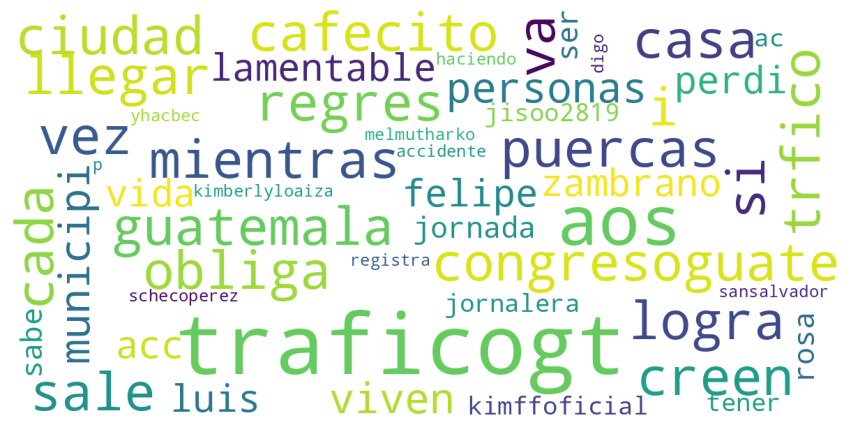

In [68]:
from wordcloud import WordCloud #graficas

def most_used_words(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
    
r1 = datos['tweet_text']
most_used_words(r1)

De las palabras más comúnes podemos ver que 1. nos encontramos con muchas palabras mal escritos, 2. entre estas palabras nos encontramos con accidente, grave y heridos. Por lo que podemos ver que muchas veces cuando se habla de tráfico en las redes sociales puede ser por algún accidente sucedido. También es importante agregar, que cafecito es una de las palabras más frecuentes de los tweets, por lo que puede ser un hábito por los conductores en el #TraficoGT.

Por limitaciones de twitter API no se puede hacer una comparación entre el tráfico pre pandemia y el tráfico que vemos ahora. por lo que de todos modos es bueno ver en una gráfica de tiempo como es que se encuentran distribuidos los tweets en estos últimos días. 

,create
2021-09-06,5301
2021-09-05,2264
2021-09-07,257
2021-09-04,49
2021-09-01,36
2021-09-03,34
2021-08-31,33
2021-08-30,28
2021-09-02,28
2021-08-29,13


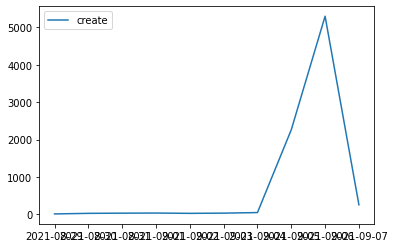

In [96]:
datos['create'] = pd.to_datetime(datos['create'], errors='coerce')

new = datos[['create']].copy()
new=new['create'].dt.date.value_counts().to_frame()
new.plot()
new

De esta gráfica y esta nuevo dataset es que mas de la mitad de los tweets buscados son de un mismo dia. Del 6 de Septiembre de 2021, cabe mencionar que hay tweets sucedidos el 7 de septiembre (que todavía no ha pasado) por lo que debe de ser analizado. 

Sin embargo, cabe mencionar que el día de hoy (6 de sept 21) no hubieron lluvias fuertes, no manifestaciones planificadas ni grandes eventos por pandemia, por lo que podría ser interesante analizar todos los textos para observar cuál fueron las causas de los accidentes u otras situaciones que terminaron en tráficoGT. 

### Conclusiones